### Code for Calculating the Velocity Profile of Chlamydomonas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
def myplot():
    plt.rcParams['font.family'] ='Arial'#使用するフォント
    plt.rcParams['xtick.direction'] = 'out'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['ytick.direction'] = 'out'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['xtick.minor.width'] = .6#x軸主目盛り線の線幅
    plt.rcParams['ytick.minor.width'] = .6#x軸主目盛り線の線幅
    plt.rcParams['xtick.major.width'] = .6#x軸主目盛り線の線幅
    plt.rcParams['ytick.major.width'] = .6#y軸主目盛り線の線幅
    plt.rcParams['font.size'] = 7 #フォントの大きさ
    plt.rcParams['axes.linewidth'] = .6# 軸の線幅edge linewidth。囲みの太さ
    plt.rcParams['figure.figsize'] = [2.5,1.6]# 図のサイズはインチで指定され、変数は(幅, 高さ)です。3.14 インチは約8cm。
    plt.rcParams['figure.dpi'] = 600

myplot()

The velocity profile is calculated by differentiating the approximating polynomial obtained by applying the Savitzky-Golay filter to the position coordinates.

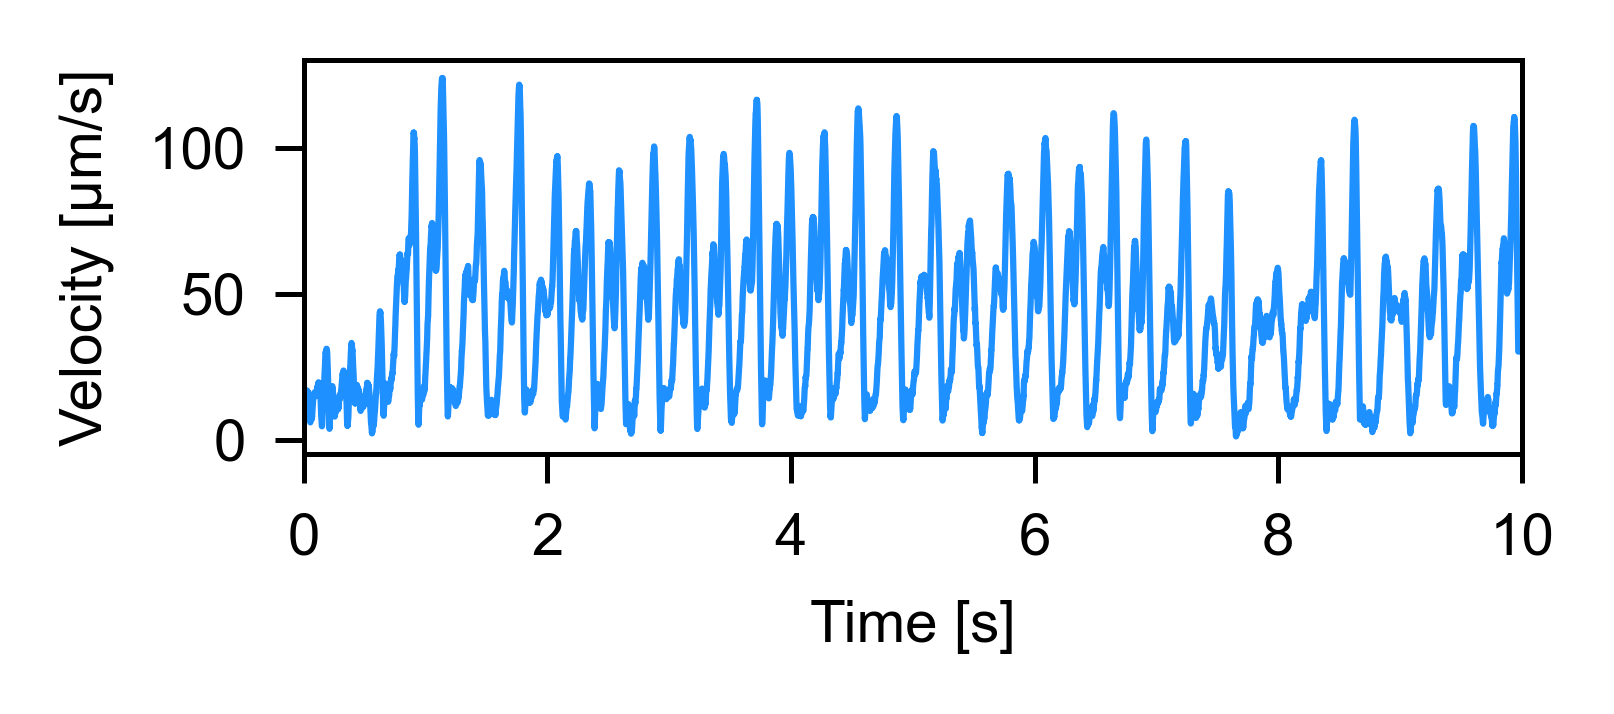

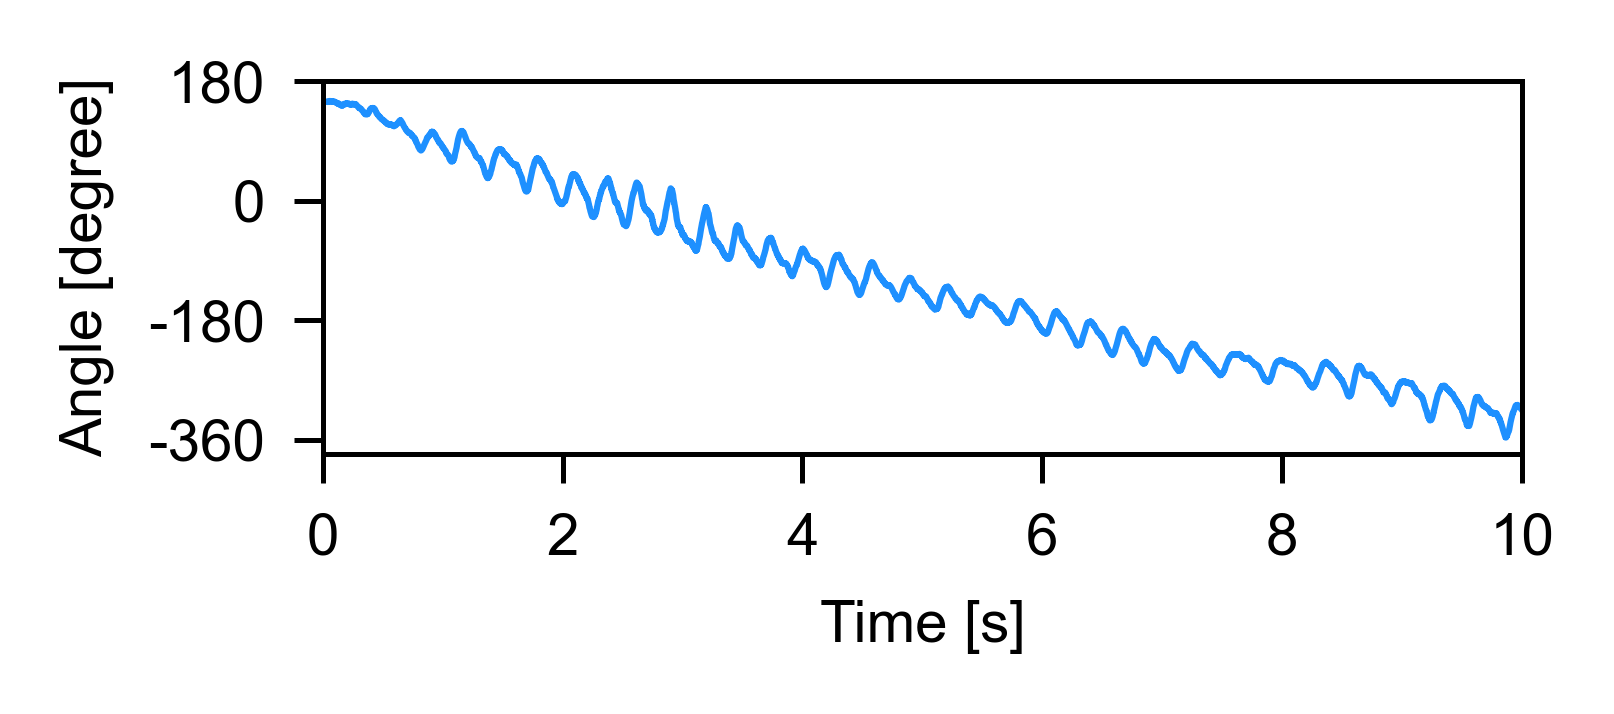

In [ ]:
# CSVファイルのパス
csv_path = r"F:\Chlamydomonas_Analysis\20241016-161347chlamyCYTO16verygood\figs\xy-rotation_updated.csv"
save_dir = r"F:\Chlamydomonas_Analysis\20241016-160147chlamyCYTO16verygood\figs"

# CSV読み込み
df = pd.read_csv(csv_path)
voxel_size = 0.4095  # μm/voxel

# 細胞Aの座標（z, y, x）
zA = df.iloc[:, 0].values* voxel_size
yA = df.iloc[:, 1].values* voxel_size
xA = df.iloc[:, 2].values* voxel_size

# 細胞Bの座標（z, y, x）
zB = df.iloc[:, 4].values* voxel_size
yB = df.iloc[:, 5].values* voxel_size
xB = df.iloc[:, 6].values* voxel_size

# Savitzky-Golayフィルタでローパス（ウィンドウ幅と次数は適宜調整）
window_length = 51  # 奇数
polyorder = 1

xA_filt = savgol_filter(xA, window_length, polyorder)
yA_filt = savgol_filter(yA, window_length, polyorder)
xB_filt = savgol_filter(xB, window_length, polyorder)
yB_filt = savgol_filter(yB, window_length, polyorder)

# xy平面での方向ベクトル
dx = xB_filt - xA_filt
dy = yB_filt - yA_filt

# 角度計算（x軸が0 rad、反時計回りが正）
theta = -np.arctan2(dy, dx)  # [-π, π]の範囲
# 位相ジャンプ（ラジアン2π分の飛び）を補正
theta_unwrap = np.unwrap(theta)
theta_deg = np.degrees(theta_unwrap)

# サンプリング間隔1kHz（1msごと）
dt = 0.001  # 秒
time = np.arange(len(theta)) * dt

# 速度（1階微分）をSGフィルタで直接計算
vxA = savgol_filter(xA, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt, mode='interp')
vyA = savgol_filter(yA, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt, mode='interp')
vzA = savgol_filter(zA, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt, mode='interp')

vxB = savgol_filter(xB, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt, mode='interp')
vyB = savgol_filter(yB, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt, mode='interp')
vzB = savgol_filter(zB, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt, mode='interp')

# 合成速度
speedA = np.sqrt(vxA**2 + vyA**2 + vzA**2)
speedB = np.sqrt(vxB**2 + vyB**2 + vzB**2)

# 時間軸
t = np.arange(len(speedA)) * dt # [μm/s]

# 差分から速度を算出（μm/s）
dxA = np.diff(xA)
dyA = np.diff(yA)
dzA = np.diff(zA)
speedA_diff = np.sqrt(dxA**2 + dyA**2 + dzA**2) / dt

dxB = np.diff(xB)
dyB = np.diff(yB)
dzB = np.diff(zB)
speedB_diff = np.sqrt(dxB**2 + dyB**2 + dzB**2) / dt

# 差分速度用の時間軸（1つ短い）
t_diff = np.arange(len(speedA_diff)) * dt

# プロット
plt.figure(figsize=[2.7,1.2])
plt.plot(t, speedA, color='dodgerblue', linewidth=.75)
# plt.plot(t, speedA, color='magenta', label=f'A: SG filtered (window={window_length}, poly={polyorder})', linewidth=1.5)
# plt.plot(t, speedB, color='springgreen', label=f'B: SG filtered (window={window_length}, poly={polyorder})', linewidth=1.5)
# plt.plot(t_diff, speedA_diff, color='blue', linestyle='--', label='A: diff', linewidth=1,alpha=0.3)
# plt.plot(t_diff, speedB_diff, color='red', linestyle='--', label='B: diff', linewidth=1)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [μm/s]')
plt.xlim(0, 10)  # ←ここでx軸範囲を指定
# plt.legend(frameon=False)
plt.tight_layout()
save_path = os.path.join(save_dir, "velocity_timetrace.tiff")
plt.savefig(save_path, dpi=600)
# tとspeedAを1列ずつのDataFrameにまとめて保存
df_velocity = pd.DataFrame({'t': t, 'velocity': speedA})
csv_save_path = os.path.join(save_dir, "time_velocity.csv")
df_velocity.to_csv(csv_save_path, index=False)

import matplotlib.ticker as ticker
from matplotlib import transforms
# プロット
plt.figure(figsize=[2.7,1.2])
plt.plot(t, theta_deg, color='dodgerblue', linewidth=.75)
plt.xlim(0, 10)  # ←ここでx軸範囲を指定
plt.xlabel('Time [s]')
plt.ylabel('Angle [degree]')

# 目盛りを-180, 0, 180, 360度に設定し、Arialで表示
ax = plt.gca()
ax.set_yticks([-360, -180, 0, 180])
ax.set_yticklabels(['-360','-180', '0', '180'], fontname='Arial')
# plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
save_path = os.path.join(save_dir, "angle_timetrace.tiff")
plt.savefig(save_path, dpi=600)
df_angle = pd.DataFrame({'t': t, 'angle': theta_deg})
csv_save_path = os.path.join(save_dir, "time_angle.csv")
df_angle.to_csv(csv_save_path, index=False)

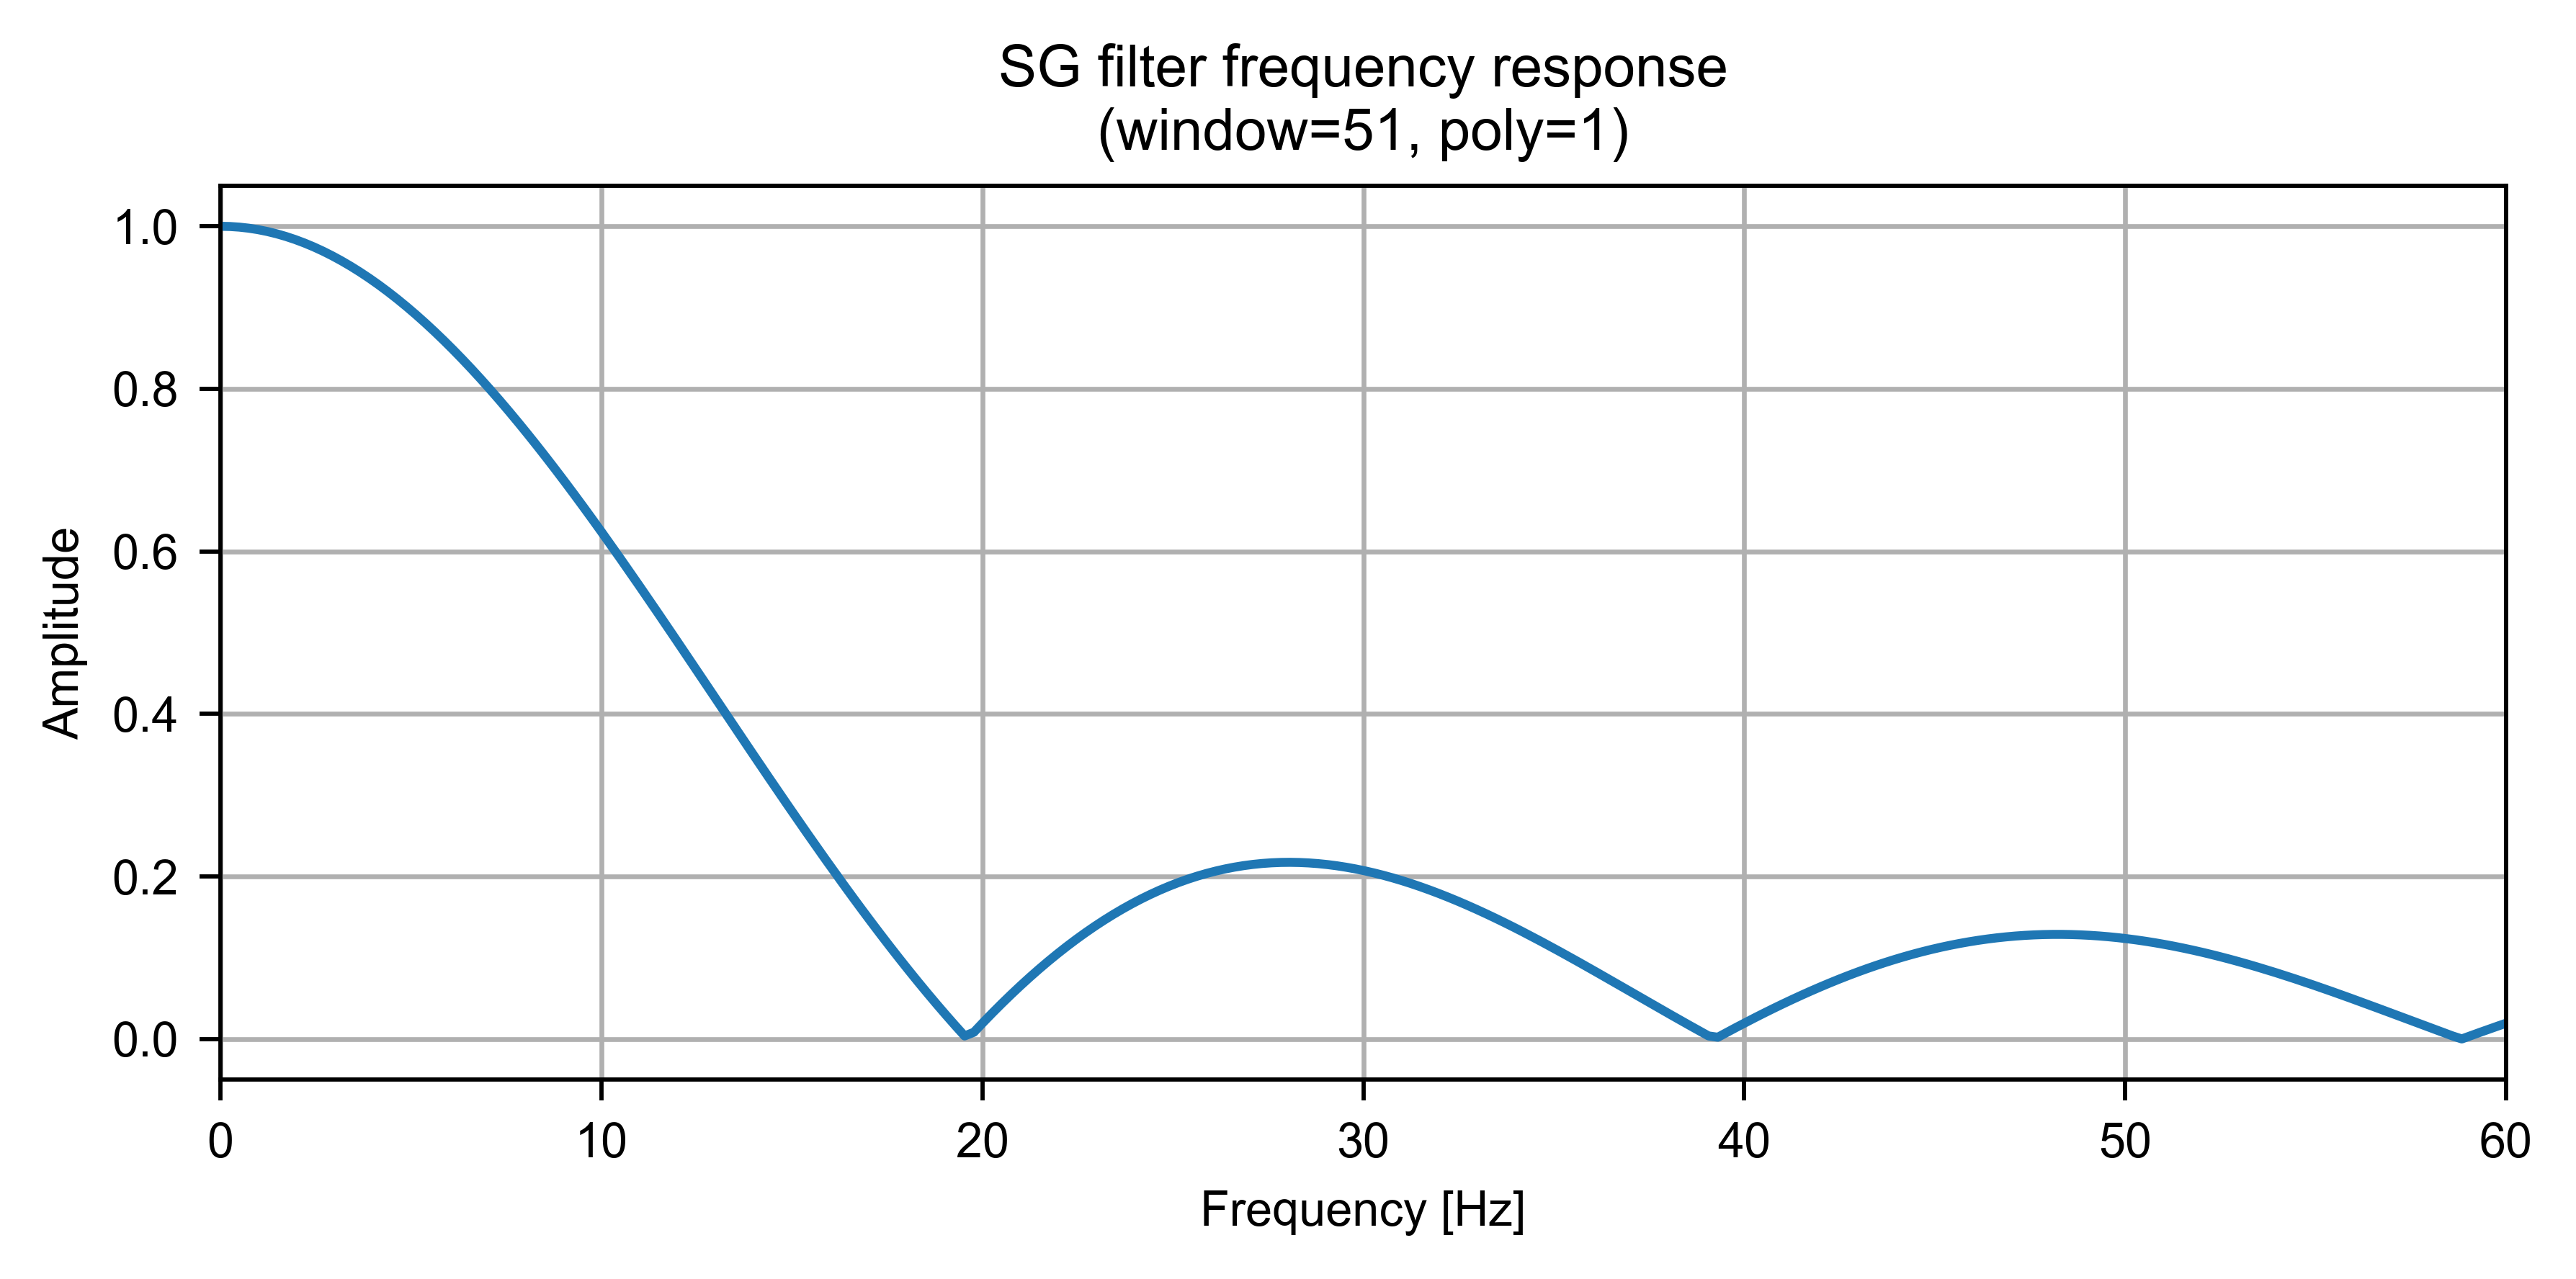

In [36]:
from scipy.signal import savgol_coeffs

# SGフィルタの係数（カーネル）を取得
coeffs = savgol_coeffs(window_length, polyorder)

# 周波数応答（FFT）
freq_response = np.abs(np.fft.fft(coeffs, 4096))
freqs = np.fft.fftfreq(4096, d=dt)  # サンプリング間隔dtを指定

# 正の周波数成分のみ表示（Hz単位）
plt.figure(figsize=(6,3))
plt.plot(freqs[:2048], freq_response[:2048])
plt.xlabel('Frequency [Hz]')
plt.xlim(0, 60)  # x軸の範囲を0-500 Hzに設定
plt.ylabel('Amplitude')
plt.title(f'SG filter frequency response\n(window={window_length}, poly={polyorder})')
plt.grid()
plt.tight_layout()
plt.show()